# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product

import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob as glob
gsname = "gs0825"
L = []
for fp in glob('data/'+gsname+'/*'):
  df_ = pd.read_csv(fp)
  L.append(df_)
gsdf = pd.concat(L)
gsdf.to_csv('data/gsdf-'+gsname+'.csv')

In [3]:
gsdf.loc[:,'mi'] = gsdf.middle-gsdf.interleaved
gsdf

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
0,0,16.50,5000.0,10.00,0.80,2.0,1.0,1.0,1.0,1.000000,0.500000,1.000000,0.500000,0.500000,0.000000
0,0,3.75,5000.0,8.00,1.16,2.0,1.0,1.0,1.0,0.506750,0.502750,0.506500,0.491000,0.500000,-0.011750
1,1,3.75,5000.0,10.00,1.16,2.0,1.0,1.0,1.0,0.486250,0.496750,0.502250,0.507500,0.509000,0.010750
0,0,10.25,5000.0,6.00,0.80,2.0,1.0,1.0,1.0,1.000000,0.500000,1.000000,0.500000,0.500000,0.000000
0,0,10.25,5000.0,8.00,0.81,2.0,1.0,1.0,1.0,1.000000,0.930359,1.000000,1.000000,1.000000,0.069641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,38,3.81,3500.0,17.00,0.71,2.0,1.0,1.0,1.0,0.496750,0.500250,0.499625,0.500687,0.498500,0.000437
39,39,3.91,3500.0,17.00,0.71,2.0,1.0,1.0,1.0,0.493375,0.495062,0.497062,0.508250,0.494562,0.013187
0,0,6.75,5000.0,8.00,0.36,2.0,1.0,1.0,1.0,1.000000,0.952377,1.000000,1.000000,1.000000,0.047623
1,1,6.75,5000.0,10.00,0.36,2.0,1.0,1.0,1.0,1.000000,0.949164,1.000000,1.000000,1.000000,0.050836


In [4]:
gsdf.concentration.max()

19.75

In [22]:
D10 = gsdf.mi > -1
B50 = gsdf.blocked > 0.4
I = gsdf.interleaved < .65
df = gsdf[D10&B50&I].sort_values('mi',ascending=False)
df

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
1,1,8.50,5000.0,10.0,0.785,2.0,1.0,1.0,1.0,1.000000,0.482776,1.000000,0.700982,0.561462,0.218205
1,1,9.50,5000.0,10.0,1.060,2.0,1.0,1.0,1.0,1.000000,0.539815,1.000000,0.752346,0.685105,0.212531
0,0,3.75,5000.0,8.0,0.260,2.0,1.0,1.0,1.0,1.000000,0.571000,1.000000,0.752250,0.592250,0.181250
1,1,6.50,5000.0,10.0,0.460,2.0,1.0,1.0,1.0,1.000000,0.584896,1.000000,0.749500,0.649250,0.164604
1,1,9.75,5000.0,10.0,1.160,2.0,1.0,1.0,1.0,1.000000,0.494969,1.000000,0.655376,0.606565,0.160407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,28,2.81,5000.0,3.0,0.535,2.0,1.0,1.0,1.0,0.502106,0.642812,0.505437,0.564125,0.604187,-0.078687
6,6,0.61,5000.0,0.0,1.185,2.0,1.0,1.0,1.0,0.497296,0.645000,0.496767,0.564125,0.598625,-0.080875
1,1,6.50,5000.0,10.0,0.535,2.0,1.0,1.0,1.0,1.000000,0.624690,1.000000,0.541500,0.575250,-0.083190
39,39,3.91,3500.0,10.0,0.235,2.0,1.0,1.0,1.0,1.000000,0.639625,0.996938,0.556125,0.549750,-0.083500


Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

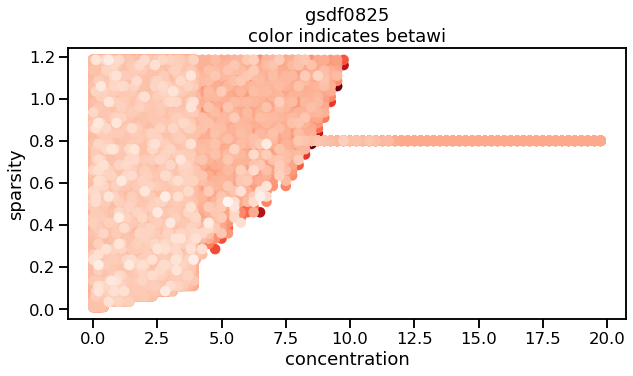

In [23]:
f,ax=plt.subplots(1,1,figsize=(10,5))

ax.scatter(df.concentration,df.sparsity,c=df.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

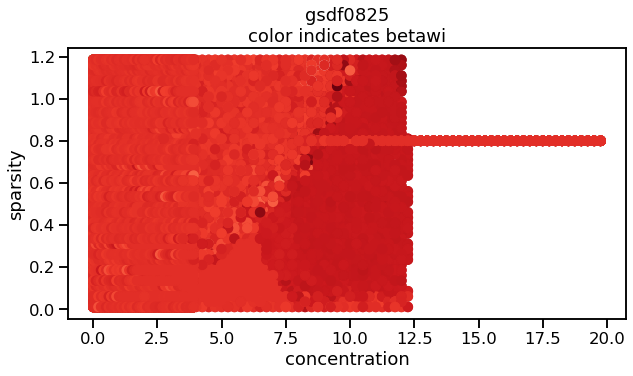

In [20]:
f,ax=plt.subplots(1,1,figsize=(10,5))
# df = gsdf
cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.sparsity,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('sparsity')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')

Text(0.5, 1.0, 'gsdf0825\ncolor indicates betawi')

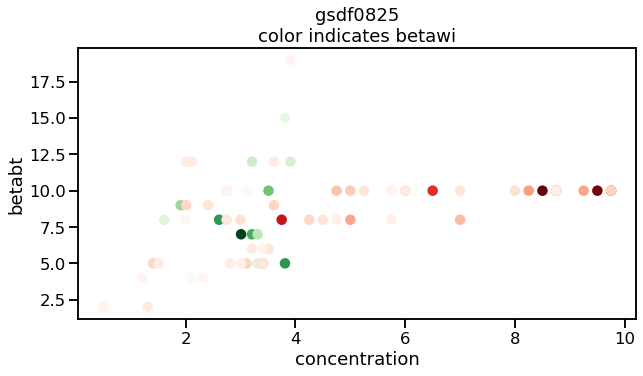

In [10]:
f,ax=plt.subplots(1,1,figsize=(10,5))

cL = ['Greens','Reds']
pname = 'stickiness_wi'
pval = [3500,5000]
for idx in range(2):
  df_ = df[df.loc[:,pname] == pval[idx]]
  ax.scatter(df_.concentration,df_.stickiness_bt,c=df_.mi,cmap=cL[idx])
ax.set_xlabel('concentration')
ax.set_ylabel('betabt')
ax.set_title('gsdf0825\ncolor indicates betawi')
# plt.savefig('figures/gsdf0825-sparsity-vs-concentration')